This notebook deals with the matter of stitching the output files of unfinished simulations due to TIMEOUTS. It is structured in 2 parts:

1. **Make fake `part1_file`**
We make a fake outputfile with the last two timesteps to use as a restart file for `backtrack_from_existing_file.py`.

2. **Stitch `part1` and `part2`**:
We stitch together part1 and part2 files of the simulations in question.

> This notebook is not generalized for all incomplete output. You need to modify it manually to get the outputs for the files you want to address.

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy

# 1. Make fake `part1_file`

In [18]:
sim = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/abyssal_nps_outputs/hc13_25000_BM_True.zarr')
sim = sim.compute()
sim = sim.dropna(dim='obs')

In [10]:
# select the last obs and create a new dataset with the last two obs
sim_last = sim.isel(obs=[-2,-1])

In [15]:
sim_last.time[0]

<xarray.DataArray 'time' (obs: 2)>
array(['2012-10-22T12:00:00.000000000', '2012-10-21T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * obs         (obs) int32 2281 2282
    trajectory  int64 0
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

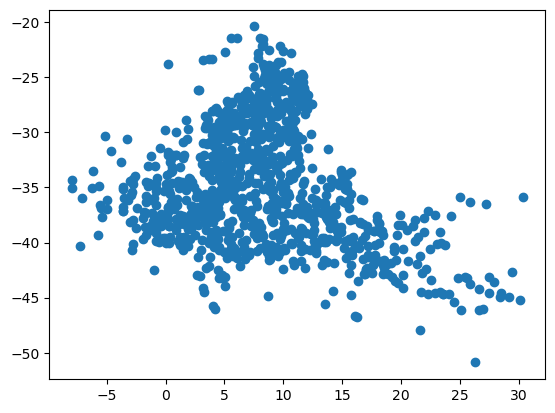

In [12]:
plt.scatter(sim_last.lon[:1000, 1], sim_last.lat[:1000, 1])

In [13]:
sim_last.to_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/abyssal_nps_outputs/hc13_25000_BM_False_lasttwo.zarr')

# 2. Stitch `part1` and `part2`

In [19]:
# Load part 1 
part1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/abyssal_nps_outputs/merge_23000/hc13_23000_BM_False_part1.zarr')
part1 = part1.compute()
part1 = part1.dropna(dim='obs') # Drop the nans because of the chunking.

In [20]:
part1

<xarray.Dataset>
Dimensions:           (trajectory: 8192, obs: 2875)
Coordinates:
  * obs               (obs) int32 0 1 2 3 4 5 ... 2869 2870 2871 2872 2873 2874
  * trajectory        (trajectory) int64 0 1 2 3 4 ... 8187 8188 8189 8190 8191
Data variables: (12/20)
    abs_salinity      (trajectory, obs) float32 34.75 34.75 ... 34.72 34.72
    bottom            (trajectory, obs) float32 5.5e+03 5.5e+03 ... 5.052e+03
    cons_temperature  (trajectory, obs) float32 0.755 0.7429 ... 0.4315 0.4132
    density           (trajectory, obs) float32 1.028e+03 ... 1.028e+03
    distance          (trajectory, obs) float32 51.0 51.0 51.0 ... 51.0 51.0
    floored           (trajectory, obs) float32 0.0 0.0 0.0 ... 77.0 77.0 77.0
    ...                ...
    u                 (trajectory, obs) float32 0.0 3.982e-07 ... -2.242e-07
    v                 (trajectory, obs) float32 0.0 -4.395e-07 ... 7.65e-07
    v_s               (trajectory, obs) float32 8.861e-08 ... 3.976e-08
    w                 (trajectory, obs) float32 0.0 -0.0002636 ... -0.0003031
    z                 (trajectory, obs) float64 5e+03 5.019e+03 ... 4.575e+03
    z_kz              (trajectory, obs) float32 0.0 1.721 ... -0.4716 0.4672
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2

In [13]:
part2 = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/abyssal_nps_outputs/hc13_23000_BM_True_lasttwo.zarr')

/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [21]:
part2

<xarray.Dataset>
Dimensions:           (trajectory: 8192, obs: 2)
Coordinates:
  * obs               (obs) int32 2873 2874
  * trajectory        (trajectory) int64 0 1 2 3 4 ... 8187 8188 8189 8190 8191
Data variables: (12/20)
    abs_salinity      (trajectory, obs) float32 ...
    bottom            (trajectory, obs) float32 ...
    cons_temperature  (trajectory, obs) float32 ...
    density           (trajectory, obs) float32 ...
    distance          (trajectory, obs) float32 ...
    floored           (trajectory, obs) float32 ...
    ...                ...
    u                 (trajectory, obs) float32 ...
    v                 (trajectory, obs) float32 ...
    v_s               (trajectory, obs) float32 ...
    w                 (trajectory, obs) float32 ...
    z                 (trajectory, obs) float64 ...
    z_kz              (trajectory, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2

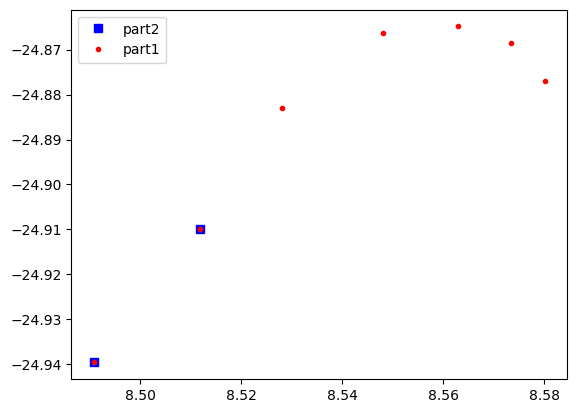

In [32]:
pp = 40

plt.plot(part2.lon[pp, :2], part2.lat[pp, :2], 'bs', label='part2')
plt.plot(part1.lon[pp,-7:], part1.lat[pp,-7:], 'r.', label='part1')
plt.legend()

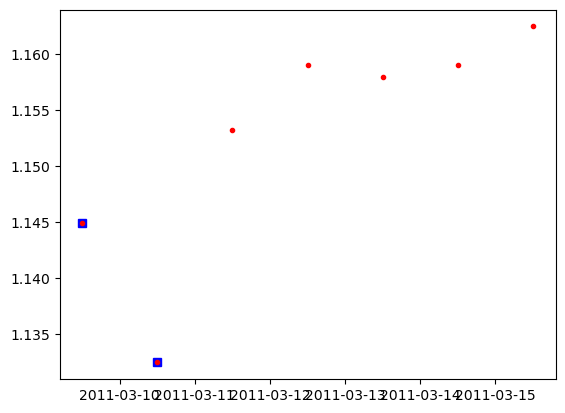

In [31]:
pp = 40
plt.plot(part2.time[pp, :2], part2.cons_temperature[pp, :2], 'bs')
plt.plot(part1.time[pp, -7:], part1.cons_temperature[pp,-7:], 'r.')

> The two first timesteps of `part2` are the last ones of `part1`. We need to drop them and concatenate both Datasets into one.

In [41]:
# The two first timesteps of `part2` are the last ones of `part1`. We need to drop them and concatenate both Datasets into one
part1_a = part1.isel(obs=slice(0,-2))


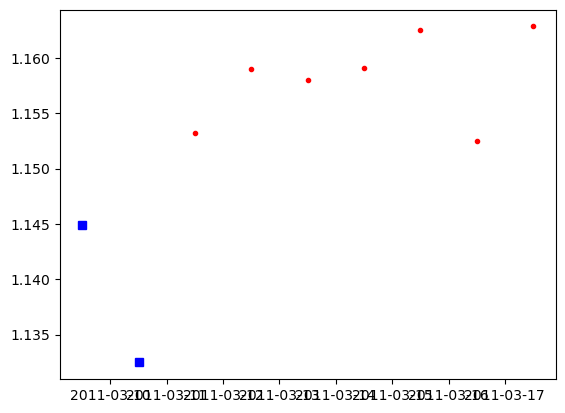

In [43]:
pp = 40
plt.plot(part2.time[pp, :2], part2.cons_temperature[pp, :2], 'bs')
plt.plot(part1_a.time[pp, -7:], part1_a.cons_temperature[pp,-7:], 'r.')

In [44]:
# concatenate both datasets in the obs dimension
full = xr.concat([part1_a, part2], dim='obs')

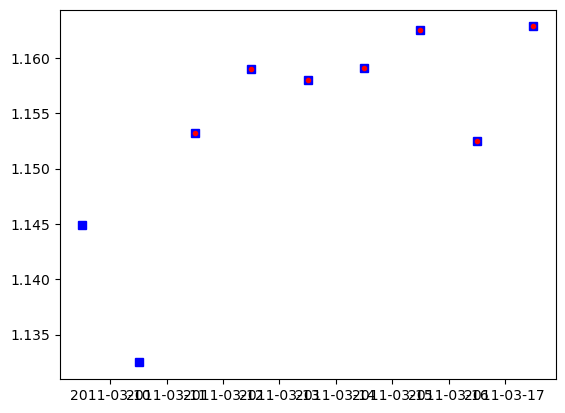

In [49]:
pp = 40
plt.plot(full.time[pp, -9:], full.cons_temperature[pp, -9:], 'bs', label='full')
plt.plot(part1_a.time[pp, -7:], part1_a.cons_temperature[pp,-7:], 'r.', label='part1_a')

In [ ]:
# save full dataset to zarr
# full.to_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/abyssal_nps_outputs/merge_23000/hc13_23000_BM_False.zarr')